# Machine Learning Kelompok 1

Prerequisite Files:
- Unet Membrane https://www.kaggle.com/datasets/tasmiarahmanaanika/unet-lung-mask

In [1]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from glob import glob
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D

# Load Dataset Training dan Valid

In [2]:
# Function to replace NaN values with 0
def replace_nan_with_zero(df, columns=None, inplace=True):
    if columns is None:
        if inplace:
            df.fillna(0, inplace=True)
            return None
        else:
            return df.fillna(0)
    else:
        # limit replacement only to the specified columns
        if inplace:
            df[columns] = df[columns].fillna(0)
            return None
        else:
            new_df = df.copy()
            new_df[columns] = new_df[columns].fillna(0)
            return new_df

In [3]:
# Number of rows to sample
n_rows = 10000

# Read and sample randomly
train_df = pd.read_csv("train.csv")
train_df.drop(columns=['_id'], inplace=True, errors='ignore')
train_df = train_df.sample(n=n_rows, random_state=42) 
train_df = train_df.reset_index(drop=True) 
train_df.head()

Path     Sex  Age  \
0  D:/Downloads/train/patient00082/study1/view1_f...    Male   18   
1  D:/Downloads/train/patient35759/study9/view1_f...    Male   90   
2  D:/Downloads/train/patient04789/study1/view2_l...    Male   39   
3  D:/Downloads/train/patient38491/study5/view1_f...    Male   60   
4  D:/Downloads/train/patient06537/study3/view1_f...  Female   66   

  Frontal_Lateral AP_PA  No_Finding  Enlarged_Cardiomediastinum  Cardiomegaly  \
0         Frontal    PA           1                           0             0   
1         Frontal    AP           0                           0             1   
2         Lateral     0           0                           0             0   
3         Frontal    AP           0                           0             0   
4         Frontal    AP           0                           0             0   

   Lung_Opacity  Lung_Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0             0            0      0              0          0            0   
1             0            0      1              0          0            1   
2             0            1      0              0          0            0   
3             0            0      1              0          0            0   
4             1            0      0              0          0            1   

   Pneumothorax  Pleural_Effusion  Pleural_Other  Fracture  Support_Devices  
0             0                 0              0         0                0  
1             0                 0              0         0                1  
2             0                 1              0         0                0  
3             0                 0              0         0                1  
4             0                 0              0         0                0

In [4]:
# Function to prepare dataset based on labeling policy 
def prepare_dataset(dataframe, policy, class_names):
    x_path = dataframe["Path"].to_numpy()
    
    y_df = dataframe[class_names]
    
    class_ones = ['Atelectasis', 'Cardiomegaly'] 
    y = np.empty(y_df.shape, dtype=int)
    
    for i, (_, row) in enumerate(y_df.iterrows()):
        labels = []
        for cls in class_names:
            curr_val = row[cls]
            feat_val = 0

            if curr_val is not None:
                try:
                    curr_val = float(curr_val)
                except:
                    curr_val = 0

                if curr_val == 1:
                    feat_val = 1
                elif curr_val == -1:
                    if policy == "ones":
                        feat_val = 1
                    elif policy == "zeroes":
                        feat_val = 0
                    elif policy == "mixed":
                        feat_val = 1 if cls in class_ones else 0
                else:
                    feat_val = 0
            labels.append(feat_val)
        y[i] = labels
    
    return x_path, y


In [5]:
# Classes used based on CheXpert paper
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural_Effusion']
policy = ['ones','zeroes','mixed']
x_path,labels = prepare_dataset(train_df,policy[-1],class_names)

In [6]:
print(policy[0])

ones


In [7]:
print(x_path)

['D:/Downloads/train/patient00082/study1/view1_frontal.jpg'
 'D:/Downloads/train/patient35759/study9/view1_frontal.jpg'
 'D:/Downloads/train/patient04789/study1/view2_lateral.jpg' ...
 'D:/Downloads/train/patient40649/study1/view1_frontal.jpg'
 'D:/Downloads/train/patient00884/study2/view1_frontal.jpg'
 'D:/Downloads/train/patient25729/study24/view1_frontal.jpg']


In [8]:
# Get data
train_df = pd.DataFrame({'path':x_path})
df2 = pd.DataFrame(labels,columns=class_names)
train_df[list(df2.columns)]=df2 

In [9]:
train_df

path  Atelectasis  \
0     D:/Downloads/train/patient00082/study1/view1_f...            0   
1     D:/Downloads/train/patient35759/study9/view1_f...            1   
2     D:/Downloads/train/patient04789/study1/view2_l...            0   
3     D:/Downloads/train/patient38491/study5/view1_f...            0   
4     D:/Downloads/train/patient06537/study3/view1_f...            1   
...                                                 ...          ...   
9995  D:/Downloads/train/patient44142/study1/view1_f...            1   
9996  D:/Downloads/train/patient15058/study21/view1_...            0   
9997  D:/Downloads/train/patient40649/study1/view1_f...            1   
9998  D:/Downloads/train/patient00884/study2/view1_f...            0   
9999  D:/Downloads/train/patient25729/study24/view1_...            1   

      Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0                0              0      0                 0  
1                1              0      1                 0  
2                0              0      0                 1  
3                0              0      1                 0  
4                0              0      0                 0  
...            ...            ...    ...               ...  
9995             0              1      0                 0  
9996             0              0      0                 0  
9997             0              0      0                 1  
9998             0              0      0                 1  
9999             1              0      1                 0  

[10000 rows x 6 columns]

Clean Labels Summary:
Pleural_Effusion    3830
Atelectasis         3019
Edema               2308
Cardiomegaly        1546
Consolidation        628
dtype: int64


(<Axes: xlabel='None', ylabel='0'>,
 ([0, 1, 2, 3, 4],
  [Text(0, 0, 'Pleural_Effusion'),
   Text(1, 0, 'Atelectasis'),
   Text(2, 0, 'Edema'),
   Text(3, 0, 'Cardiomegaly'),
   Text(4, 0, 'Consolidation')]))

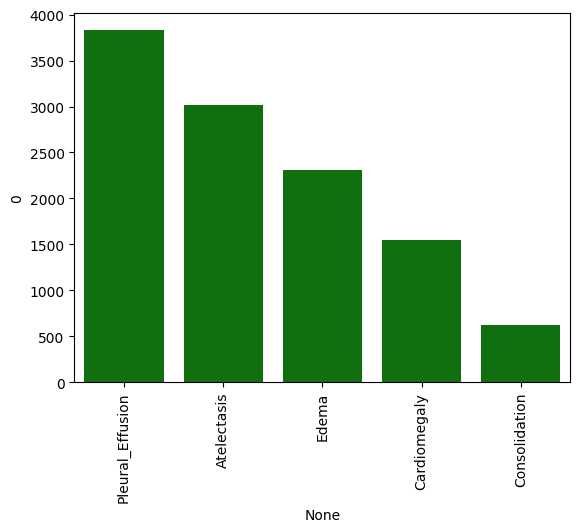

In [10]:
print("Clean Labels Summary:")
clean_labels = train_df[class_names].sum().sort_values(ascending= False) # get sorted value_count for clean labels
print(clean_labels) # view tabular results

# plot cases using seaborn barchart
clean_labels_df = clean_labels.to_frame() # convert to dataframe for plotting purposes
sns.barplot(x = clean_labels_df.index[::], y= 0, data = clean_labels_df[::], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

In [11]:
# get valid dataset
valid_df = pd.read_csv("valid.csv")
valid_df.drop(columns=['_id'], inplace=True, errors='ignore')
# Replace any NaNs with 0 
replace_nan_with_zero(valid_df)
valid_df.head()

Path     Sex  Age  \
0  CheXpert-v1.0-small/valid/patient64541/study1/...    Male   73   
1  CheXpert-v1.0-small/valid/patient64542/study1/...    Male   70   
2  CheXpert-v1.0-small/valid/patient64542/study1/...    Male   70   
3  CheXpert-v1.0-small/valid/patient64543/study1/...    Male   85   
4  CheXpert-v1.0-small/valid/patient64544/study1/...  Female   42   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         0.0                         1.0           1.0   
1         Frontal    PA         0.0                         0.0           0.0   
2         Lateral     0         0.0                         0.0           0.0   
3         Frontal    AP         0.0                         1.0           0.0   
4         Frontal    AP         1.0                         0.0           0.0   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           1.0          0.0    0.0            0.0        0.0          0.0   
1           0.0          0.0    0.0            0.0        0.0          0.0   
2           0.0          0.0    0.0            0.0        0.0          0.0   
3           1.0          0.0    1.0            0.0        0.0          0.0   
4           0.0          0.0    0.0            0.0        0.0          0.0   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               0.0            0.0       0.0              0.0  
1           0.0               0.0            0.0       0.0              1.0  
2           0.0               0.0            0.0       0.0              1.0  
3           0.0               0.0            0.0       0.0              0.0  
4           0.0               0.0            0.0       0.0              0.0

In [12]:
my_glob_valid = [x.replace('\\', '/') for x in glob('D:/Downloads/valid/patient*/study*/*.jpg')]
print('Number of Observations: ', len(my_glob_valid)) 

Number of Observations:  234


In [13]:
images_directory_valid = "D:/Downloads/valid"

full_img_paths = {}

# Full image mapping (source images)
for x in my_glob_valid:
    rel_path = os.path.relpath(x, images_directory_valid)
    key = 'CheXpert-v1.0-small/valid/' + rel_path.replace('\\', '/')
    full_img_paths[key] = x.replace('\\', '/')
    
# Map the correct paths to the dataframe
valid_df['Path'] = valid_df['Path'].map(full_img_paths.get)
valid_df.columns = valid_df.columns.str.replace(' ', '_')

In [14]:
valid_x_path,valid_labels = prepare_dataset(valid_df,policy[-1],class_names)

In [15]:
valid_df = pd.DataFrame({'path':valid_x_path})
df2 = pd.DataFrame(labels,columns=class_names)
valid_df[list(df2.columns)]=df2 
valid_df

path  Atelectasis  \
0    D:/Downloads/valid/patient64541/study1/view1_f...            0   
1    D:/Downloads/valid/patient64542/study1/view1_f...            1   
2    D:/Downloads/valid/patient64542/study1/view2_l...            0   
3    D:/Downloads/valid/patient64543/study1/view1_f...            0   
4    D:/Downloads/valid/patient64544/study1/view1_f...            1   
..                                                 ...          ...   
229  D:/Downloads/valid/patient64736/study1/view1_f...            1   
230  D:/Downloads/valid/patient64737/study1/view1_f...            1   
231  D:/Downloads/valid/patient64738/study1/view1_f...            0   
232  D:/Downloads/valid/patient64739/study1/view1_f...            0   
233  D:/Downloads/valid/patient64740/study1/view1_f...            0   

     Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0               0              0      0                 0  
1               1              0      1                 0  
2               0              0      0                 1  
3               0              0      1                 0  
4               0              0      0                 0  
..            ...            ...    ...               ...  
229             0              0      0                 1  
230             0              0      0                 0  
231             0              0      0                 0  
232             0              0      0                 0  
233             0              0      1                 1  

[234 rows x 6 columns]

In [16]:
my_glob_train = train_df['path'].tolist()
print('Number of Observations: ', len(my_glob_train)) 

Number of Observations:  10000


In [17]:
print(my_glob_train)

['D:/Downloads/train/patient00082/study1/view1_frontal.jpg', 'D:/Downloads/train/patient35759/study9/view1_frontal.jpg', 'D:/Downloads/train/patient04789/study1/view2_lateral.jpg', 'D:/Downloads/train/patient38491/study5/view1_frontal.jpg', 'D:/Downloads/train/patient06537/study3/view1_frontal.jpg', 'D:/Downloads/train/patient21775/study11/view2_lateral.jpg', 'D:/Downloads/train/patient17583/study1/view2_lateral.jpg', 'D:/Downloads/train/patient38858/study4/view1_frontal.jpg', 'D:/Downloads/train/patient44406/study9/view1_frontal.jpg', 'D:/Downloads/train/patient50318/study1/view1_frontal.jpg', 'D:/Downloads/train/patient49769/study1/view1_frontal.jpg', 'D:/Downloads/train/patient15188/study5/view1_frontal.jpg', 'D:/Downloads/train/patient52954/study4/view1_frontal.jpg', 'D:/Downloads/train/patient53551/study1/view1_frontal.jpg', 'D:/Downloads/train/patient50547/study1/view3_lateral.jpg', 'D:/Downloads/train/patient09798/study3/view1_frontal.jpg', 'D:/Downloads/train/patient25914/study

# Resize Gambar

In [18]:
import cv2
import numpy as np

# function to resize input image with padding
def resize_with_padding(img, target_size=224, pad_color=0):
    h, w = img.shape[:2]

    # Scale with ratio maintained
    if h > w:
        new_h = target_size
        new_w = int(w * (target_size / h))
    else:
        new_w = target_size
        new_h = int(h * (target_size / w))

    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Calculate padding
    pad_vert = target_size - new_h
    pad_horz = target_size - new_w

    top = pad_vert // 2
    bottom = pad_vert - top
    left = pad_horz // 2
    right = pad_horz - left

    # Add padding
    padded = cv2.copyMakeBorder(
        resized,
        top, bottom, left, right,
        cv2.BORDER_CONSTANT,
        value=pad_color,
    )

    return padded


In [19]:
def get_all_images(root_dir):
    exts = [".png", ".jpg", ".jpeg", ".bmp"]
    collected = []

    for root, dirs, files in os.walk(root_dir):
        for f in files:
            if any(f.lower().endswith(e) for e in exts):
                collected.append(os.path.join(root, f))

    return collected

Pengaturan Direktori dan Resize Gambar

In [20]:
import cv2
from tqdm import tqdm

# resized directory 
resized_valid = "D:/Downloads/valid_resized"
resized_train = "D:/Downloads/train_resized"

TARGET_SIZE = 256
PAD_COLOR = 0 

In [21]:
def resize_images(my_glob, resized_output_dir):
    processed = 0
    failed = 0
    
    os.makedirs(resized_output_dir, exist_ok=True)
    
    glob = []
    valid_extensions = {".jpg", ".jpeg", ".png"}

    for root, dirs, files in os.walk(resized_output_dir):
        for file in files:
            name, ext = os.path.splitext(file)
            if ext.lower() in valid_extensions:
                glob.append(os.path.join(root, file))
    
    if glob:
        print(f"Found {len(glob)} resized images.")
        return glob
    else:
        print("No resized images found.")

        for img_path in tqdm(my_glob, desc="Resizing images"):
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            if img is None:
                print(f"Failed to read image: {img_path}")
                failed += 1
                continue

            resized_img = resize_with_padding(img, target_size=TARGET_SIZE, pad_color=PAD_COLOR)

            # Build relative path from the glob path
            parts = img_path.replace("\\", "/").split("/")
            rel = "/".join(parts[3:])  # keep everything after the top-level folder

            out_path = os.path.join(resized_output_dir, rel)
            os.makedirs(os.path.dirname(out_path), exist_ok=True)

            if resized_img.dtype != np.uint8:
                max_val = resized_img.max() or 1.0
                if max_val <= 1.0:
                    save_img = (resized_img * 255).astype(np.uint8)
                else:
                    save_img = resized_img.astype(np.uint8)
            else:
                save_img = resized_img

            success = cv2.imwrite(out_path, save_img)
            if not success:
                print(f"Failed to save: {out_path}")
                failed += 1
                continue
            
            processed += 1
            glob.append(out_path)
            
        print(f"Done. Processed: {processed}, Failed: {failed}")    
        return glob


In [22]:
glob_valid_resize = resize_images(my_glob_valid, resized_valid)

Found 234 resized images.


In [23]:
glob_train_resize = resize_images(my_glob_train, resized_train)

Found 10000 resized images.


In [24]:
print(glob_valid_resize)

['D:/Downloads/valid_resized\\patient64541\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64542\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64542\\study1\\view2_lateral.jpg', 'D:/Downloads/valid_resized\\patient64543\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64544\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64545\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64546\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64547\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64547\\study1\\view2_frontal.jpg', 'D:/Downloads/valid_resized\\patient64547\\study1\\view3_lateral.jpg', 'D:/Downloads/valid_resized\\patient64548\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64549\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64550\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64551\\study1\\view1_frontal.jpg', 'D:/D

In [25]:
print(glob_train_resize)

['D:/Downloads/train_resized\\patient00006\\study1\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00012\\study3\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00023\\study6\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00039\\study7\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00042\\study1\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00059\\study1\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00066\\study1\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00067\\study3\\view2_lateral.jpg', 'D:/Downloads/train_resized\\patient00069\\study17\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00069\\study27\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00069\\study43\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00081\\study1\\view2_frontal.jpg', 'D:/Downloads/train_resized\\patient00082\\study1\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00084\\study2\\view1_frontal.jpg', 'D

In [26]:
def replace_path(dataframe, glob):
    mapping = {}
    for path, new_path in zip(dataframe['path'], glob):
        mapping[path.replace("\\", "/")] = new_path.replace("\\", "/")
        
    dataframe['path'] = dataframe['path'].map(mapping.get)
    return dataframe

In [27]:
valid_df = replace_path(valid_df, glob_valid_resize)
valid_df

path  Atelectasis  \
0    D:/Downloads/valid_resized/patient64541/study1...            0   
1    D:/Downloads/valid_resized/patient64542/study1...            1   
2    D:/Downloads/valid_resized/patient64542/study1...            0   
3    D:/Downloads/valid_resized/patient64543/study1...            0   
4    D:/Downloads/valid_resized/patient64544/study1...            1   
..                                                 ...          ...   
229  D:/Downloads/valid_resized/patient64736/study1...            1   
230  D:/Downloads/valid_resized/patient64737/study1...            1   
231  D:/Downloads/valid_resized/patient64738/study1...            0   
232  D:/Downloads/valid_resized/patient64739/study1...            0   
233  D:/Downloads/valid_resized/patient64740/study1...            0   

     Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0               0              0      0                 0  
1               1              0      1                 0  
2               0              0      0                 1  
3               0              0      1                 0  
4               0              0      0                 0  
..            ...            ...    ...               ...  
229             0              0      0                 1  
230             0              0      0                 0  
231             0              0      0                 0  
232             0              0      0                 0  
233             0              0      1                 1  

[234 rows x 6 columns]

In [28]:
train_df = replace_path(train_df, glob_train_resize)
train_df

path  Atelectasis  \
0     D:/Downloads/train_resized/patient00006/study1...            0   
1     D:/Downloads/train_resized/patient00012/study3...            1   
2     D:/Downloads/train_resized/patient00023/study6...            0   
3     D:/Downloads/train_resized/patient00039/study7...            0   
4     D:/Downloads/train_resized/patient00042/study1...            1   
...                                                 ...          ...   
9995  D:/Downloads/train_resized/patient64491/study2...            1   
9996  D:/Downloads/train_resized/patient64498/study1...            0   
9997  D:/Downloads/train_resized/patient64501/study1...            1   
9998  D:/Downloads/train_resized/patient64506/study1...            0   
9999  D:/Downloads/train_resized/patient64537/study1...            1   

      Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0                0              0      0                 0  
1                1              0      1                 0  
2                0              0      0                 1  
3                0              0      1                 0  
4                0              0      0                 0  
...            ...            ...    ...               ...  
9995             0              1      0                 0  
9996             0              0      0                 0  
9997             0              0      0                 1  
9998             0              0      0                 1  
9999             1              0      1                 0  

[10000 rows x 6 columns]

# Membuat Mask untuk Gambar

Load model Unet Membrane

In [29]:
from keras.models import load_model

mask_model = load_model("unet_membrane_a6.hdf5")
mask_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
print(mask_model.input_shape)

(None, 256, 256, 1)


In [31]:
mask_output_valid = "D:/Downloads/masks/valid"
mask_output_train = "D:/Downloads/masks/train"

In [32]:
def preprocess_image(file_path, target_size=(256, 256)):
    img = cv2.imread(file_path)
    if img is None:
        print(f"Error: Unable to read image at {file_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, target_size)
    img = cv2.GaussianBlur(img, (5,5), 0)  # reduce noise
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)   # Add batch dimension
    img = img / 255.0  # Normalize to [0, 1]
    return img

In [33]:
def predict_mask(model, image, verbose=0): 
    pred = model.predict(image, verbose=verbose) * 255
    return pred

In [34]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def predict_mask_image(path_glob, output_directory):
    glob = []
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
        
    valid_extensions = {".jpg", ".jpeg", ".png"}

    for root, dirs, files in os.walk(output_directory):
        for file in files:
            name, ext = os.path.splitext(file)
            if ext.lower() in valid_extensions and name.endswith("_mask"):
                glob.append(os.path.join(root, file))
    
    if glob:
        print(f"Found {len(glob)} masks.")
        return glob
    else:
        print("No mask found.")
        for image_path in tqdm(path_glob, desc="Generating masks", unit="img" ):
            test_im = preprocess_image(image_path)
            if test_im is None:
                tqdm.write(f"Failed to preprocess: {image_path}")
                continue

            try:
                mask = predict_mask(mask_model, test_im, verbose=0)
                
                parts = image_path.replace("\\", "/").split("/")
                relative_path = "/".join(parts[3:])  # keep everything after the top-level folder
                mask_path = os.path.join(output_directory, relative_path)
                os.makedirs(os.path.dirname(mask_path), exist_ok=True)
                
                directory, filename = os.path.split(mask_path)
                name, ext = os.path.splitext(filename)
                new_filename = f"{name}_mask{ext}"
                mask_path = os.path.join(directory, new_filename)

                os.makedirs(directory, exist_ok=True)

                mask_to_save = mask[0, :, :, 0]

                se_3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
                se_5 = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
                dst_dilate_inv = cv2.dilate(mask_to_save, se_3, iterations = 1)
                dst_erosi_inv = cv2.erode(dst_dilate_inv, se_3, iterations = 2)
                dst_dilate2_inv = cv2.dilate(dst_erosi_inv, se_5, iterations = 2)
                dst_erosi2_inv = cv2.erode(dst_dilate2_inv, se_5, iterations = 3)
                dst_dilate3_inv = cv2.dilate(dst_erosi2_inv, se_3, iterations = 1)
                mask_to_save = dst_dilate3_inv

                if mask_to_save.dtype != np.uint8:
                    if mask_to_save.max() <= 1.0:
                        mask_to_save = (mask_to_save * 255).astype(np.uint8)
                    else:
                        mask_to_save = mask_to_save.astype(np.uint8)

                if cv2.imwrite(mask_path, mask_to_save):
                    glob.append(mask_path)
                else:
                    tqdm.write(f"Failed to save: {mask_path}")

            except Exception as e:
                tqdm.write(f"Error processing {image_path}: {e}")

        return glob


Membuat mask untuk dataset training dan validasi

In [35]:
mask_glob_train = predict_mask_image(glob_train_resize, mask_output_train)

Found 10000 masks.


In [36]:
mask_glob_valid = predict_mask_image(glob_valid_resize, mask_output_valid)

Found 234 masks.


Menampilkan 5 gambar acak dengan masknya

In [37]:
import os
import random
import math
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def _make_key(path, levels=3):
    p = Path(os.path.normpath(path))
    parts = [part for part in p.parts if part not in (".", "..")]
    if len(parts) == 0:
        return ""
    last = parts[-levels:]
    # replace final segment with its stem (no extension)
    last[-1] = Path(last[-1]).stem
    return "/".join(last)

def display_resized_samples(image_glob, mask_glob, num_samples=10, key_levels=3, random_seed=None):
    if random_seed is not None:
        random.seed(random_seed)

    # normalize paths and build mask lookup by key
    image_glob = [os.path.normpath(p).replace("\\", "/") for p in image_glob]
    mask_glob = [os.path.normpath(p).replace("\\", "/") for p in mask_glob]

    mask_dict = {}
    for m in mask_glob:
        key = _make_key(m, levels=key_levels)
        # remove trailing "_mask" from the file-stem part of the key if present
        if key.endswith("_mask"):
            key = key[:-5]
        mask_dict[key] = m

    # limit samples
    num_samples = min(num_samples, len(image_glob))
    samples = random.sample(image_glob, num_samples)

    num_columns = 2
    num_rows = num_samples

    plt.figure(figsize=(12, num_rows * 3))

    for i, img_path in enumerate(samples, start=1):
        key = _make_key(img_path, levels=key_levels)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read image: {img_path}")
            continue
        try:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except Exception:
            img_rgb = img

        mask_path = mask_dict.get(key)
        mask = None
        if mask_path:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Found mask path but failed to read mask: {mask_path}")

        print(f"[{i}] image: {img_path}")
        print(f"[{i}] key: {key}")
        print(f"[{i}] mask: {mask_path if mask_path else 'NOT FOUND'}")

        # plot image
        plt.subplot(num_rows, num_columns, 2*i - 1)
        plt.imshow(img_rgb)
        plt.title("Resized Image")
        plt.axis("off")

        # plot mask or placeholder
        plt.subplot(num_rows, num_columns, 2*i)
        if mask is not None:
            plt.imshow(mask, cmap="gray")
            plt.title("Resized Mask")
        else:
            plt.text(0.5, 0.5, "Mask not found", ha="center", va="center", fontsize=12)
            plt.title("Missing Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


[1] image: D:/Downloads/valid_resized/patient64599/study1/view1_frontal.jpg
[1] key: patient64599/study1/view1_frontal
[1] mask: D:/Downloads/masks/valid/patient64599/study1/view1_frontal_mask.jpg
[2] image: D:/Downloads/valid_resized/patient64676/study1/view1_frontal.jpg
[2] key: patient64676/study1/view1_frontal
[2] mask: D:/Downloads/masks/valid/patient64676/study1/view1_frontal_mask.jpg
[3] image: D:/Downloads/valid_resized/patient64565/study1/view1_frontal.jpg
[3] key: patient64565/study1/view1_frontal
[3] mask: D:/Downloads/masks/valid/patient64565/study1/view1_frontal_mask.jpg
[4] image: D:/Downloads/valid_resized/patient64702/study1/view1_frontal.jpg
[4] key: patient64702/study1/view1_frontal
[4] mask: D:/Downloads/masks/valid/patient64702/study1/view1_frontal_mask.jpg
[5] image: D:/Downloads/valid_resized/patient64584/study1/view2_lateral.jpg
[5] key: patient64584/study1/view2_lateral
[5] mask: D:/Downloads/masks/valid/patient64584/study1/view2_lateral_mask.jpg


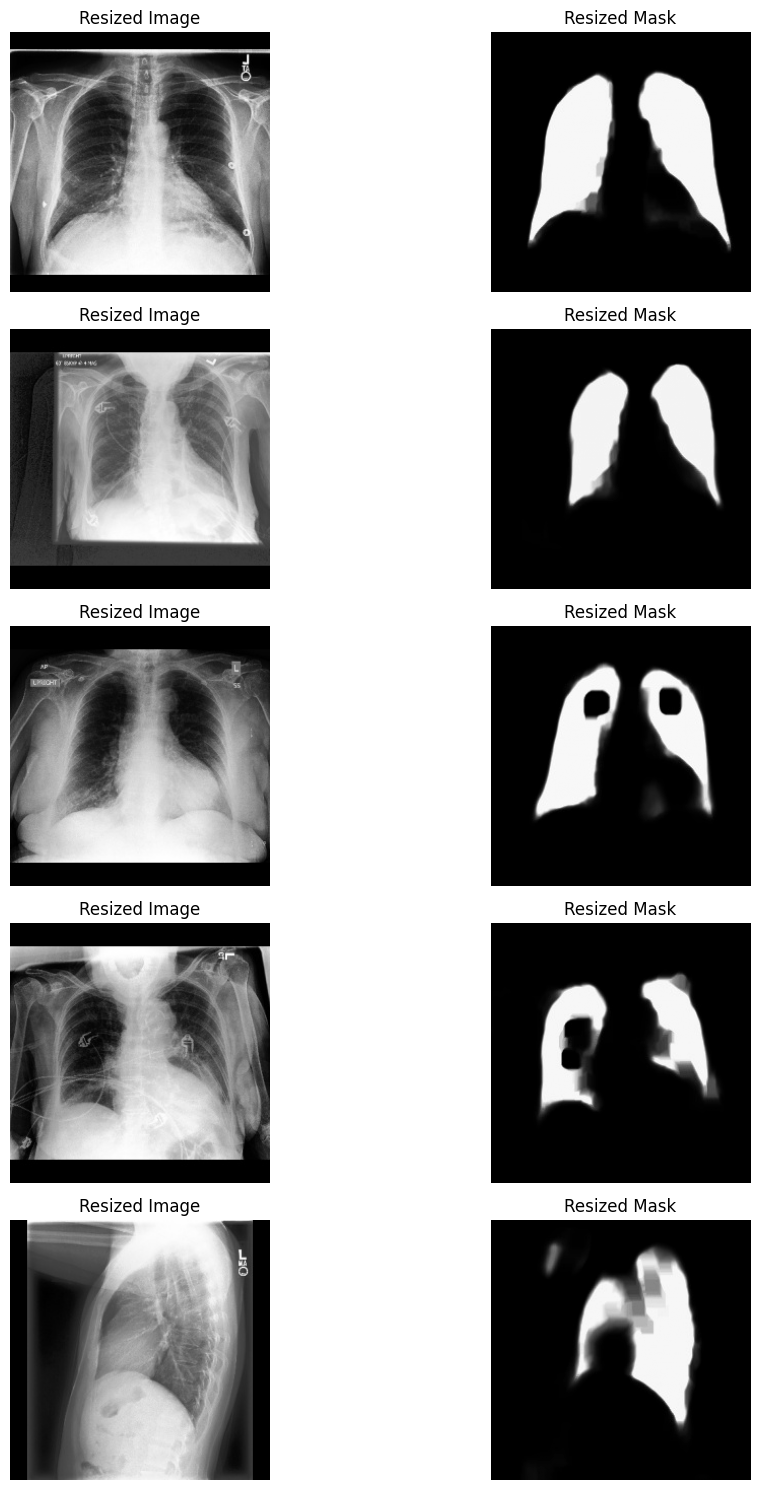

In [38]:
display_resized_samples(glob_valid_resize, mask_glob_valid, key_levels=3, num_samples=5)

[1] image: D:/Downloads/train_resized/patient27164/study1/view1_frontal.jpg
[1] key: patient27164/study1/view1_frontal
[1] mask: D:/Downloads/masks/train/patient27164/study1/view1_frontal_mask.jpg
[2] image: D:/Downloads/train_resized/patient17382/study23/view1_frontal.jpg
[2] key: patient17382/study23/view1_frontal
[2] mask: D:/Downloads/masks/train/patient17382/study23/view1_frontal_mask.jpg
[3] image: D:/Downloads/train_resized/patient09913/study3/view1_frontal.jpg
[3] key: patient09913/study3/view1_frontal
[3] mask: D:/Downloads/masks/train/patient09913/study3/view1_frontal_mask.jpg
[4] image: D:/Downloads/train_resized/patient30473/study5/view1_frontal.jpg
[4] key: patient30473/study5/view1_frontal
[4] mask: D:/Downloads/masks/train/patient30473/study5/view1_frontal_mask.jpg
[5] image: D:/Downloads/train_resized/patient12773/study5/view1_frontal.jpg
[5] key: patient12773/study5/view1_frontal
[5] mask: D:/Downloads/masks/train/patient12773/study5/view1_frontal_mask.jpg


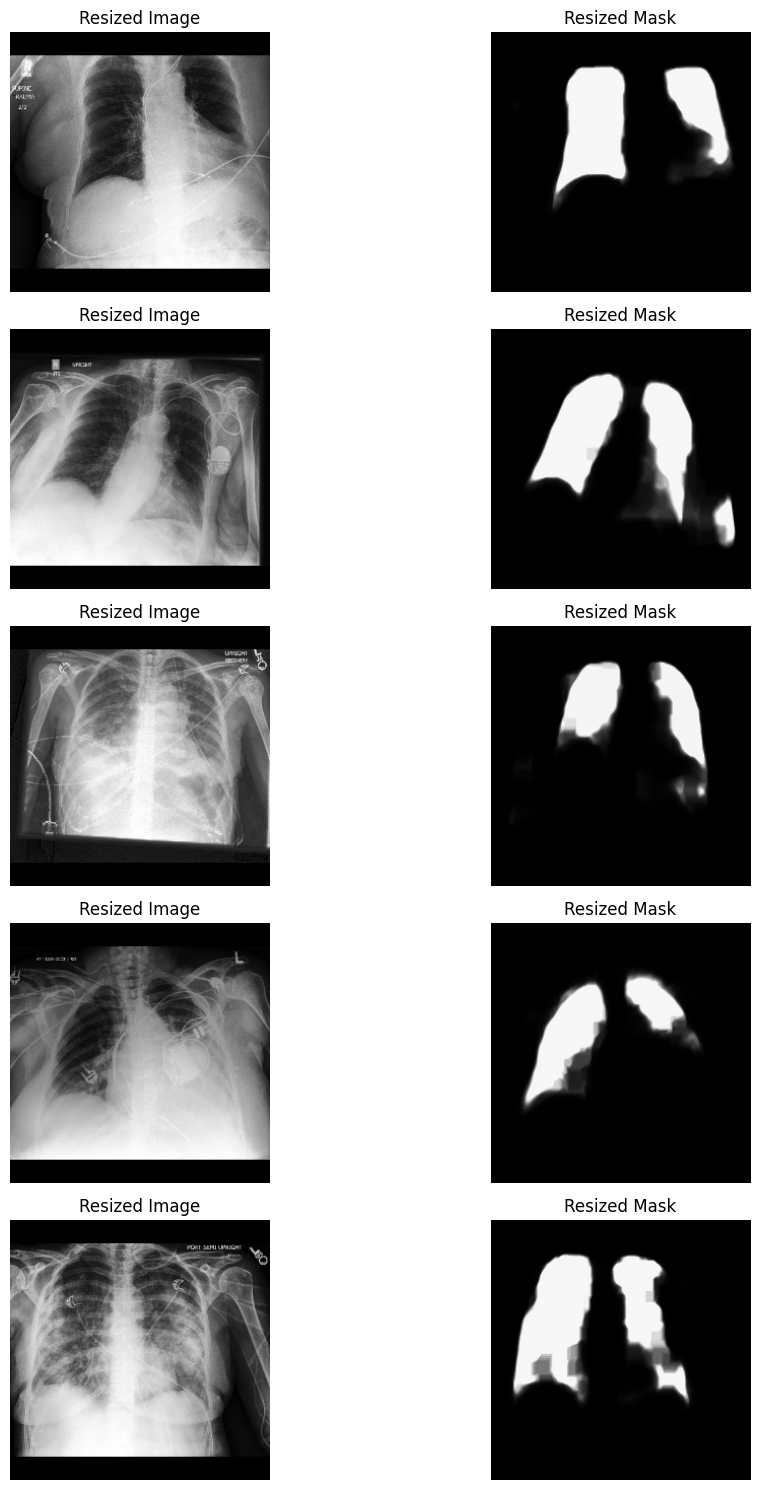

In [39]:
display_resized_samples(glob_train_resize, mask_glob_train, key_levels=3, num_samples=5)

# Menggabungkan Mask dengan Gambar Asli

In [40]:
def convolutionize_mask(mask_glob, resize_glob, output_directory):
    os.makedirs(output_directory, exist_ok=True)
    glob = []
    
    for mask_path, image_path in zip(mask_glob, resize_glob):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if mask is None or image is None:
            print(f"Failed to read mask or image: {mask_path}, {image_path}")
            continue
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Convert mask to weights 0–1
        mask_float = mask.astype("float32") / 255.0

        # Convolve the image with a Gaussian kernel
        blurred = cv2.GaussianBlur(image, (5, 5), 0)

        # Convolution-style combination
        result = image * mask_float + blurred * (1 - mask_float)
        result = np.clip(result, 0, 255).astype("uint8")
        
        # Build output path
        parts = image_path.replace("\\", "/").split("/")
        relative_path = "/".join(parts[3:])
        output_path = os.path.join(output_directory, relative_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        directory, filename = os.path.split(output_path)
        name, ext = os.path.splitext(filename)
        new_filename = f"{name}_conv{ext}"
        output_path = os.path.join(directory, new_filename)
        
        # Save result
        success = cv2.imwrite(output_path, result)
        if success:
            print(f"✓ Saved: {output_path}")
            glob.append(output_path)
        else:
            print(f"✗ Failed to save: {output_path}")
    
    return glob


In [41]:
def check_convolutionized_images(mask_glob, img_glob, root_dir):
    valid_extensions = {".jpg", ".jpeg", ".png"}
    found = []
    os.makedirs(root_dir, exist_ok=True)

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            name, ext = os.path.splitext(file)
            if ext.lower() in valid_extensions and name.endswith("_conv"):
                found.append(os.path.join(root, file))
    
    if found:
        print(f"Found {len(found)} convolutionized images.")
        return found
    else:
        print("No convolutionized images found. Proceed to generate convolutionized images.")
        return convolutionize_mask(mask_glob, img_glob, root_dir)

In [42]:
conv_output_valid = "D:/Downloads/conv_valid"
conv_glob_valid = check_convolutionized_images(mask_glob_valid, glob_valid_resize, conv_output_valid)

Found 234 convolutionized images.


In [43]:
conv_output_train = "D:/Downloads/conv_train"
conv_glob_train = check_convolutionized_images(mask_glob_train, glob_train_resize, conv_output_train)

Found 10000 convolutionized images.


In [44]:
valid_df = replace_path(valid_df, conv_glob_valid)
valid_df

path  Atelectasis  \
0    D:/Downloads/conv_valid/patient64541/study1/vi...            0   
1    D:/Downloads/conv_valid/patient64542/study1/vi...            1   
2    D:/Downloads/conv_valid/patient64542/study1/vi...            0   
3    D:/Downloads/conv_valid/patient64543/study1/vi...            0   
4    D:/Downloads/conv_valid/patient64544/study1/vi...            1   
..                                                 ...          ...   
229  D:/Downloads/conv_valid/patient64736/study1/vi...            1   
230  D:/Downloads/conv_valid/patient64737/study1/vi...            1   
231  D:/Downloads/conv_valid/patient64738/study1/vi...            0   
232  D:/Downloads/conv_valid/patient64739/study1/vi...            0   
233  D:/Downloads/conv_valid/patient64740/study1/vi...            0   

     Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0               0              0      0                 0  
1               1              0      1                 0  
2               0              0      0                 1  
3               0              0      1                 0  
4               0              0      0                 0  
..            ...            ...    ...               ...  
229             0              0      0                 1  
230             0              0      0                 0  
231             0              0      0                 0  
232             0              0      0                 0  
233             0              0      1                 1  

[234 rows x 6 columns]

In [45]:
train_df = replace_path(train_df, conv_glob_train)
train_df.head()

path  Atelectasis  \
0  D:/Downloads/conv_train/patient00006/study1/vi...            0   
1  D:/Downloads/conv_train/patient00012/study3/vi...            1   
2  D:/Downloads/conv_train/patient00023/study6/vi...            0   
3  D:/Downloads/conv_train/patient00039/study7/vi...            0   
4  D:/Downloads/conv_train/patient00042/study1/vi...            1   

   Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0             0              0      0                 0  
1             1              0      1                 0  
2             0              0      0                 1  
3             0              0      1                 0  
4             0              0      0                 0

In [46]:
IMG_SIZE = (256,256)
CHANNELS = 3

In [47]:
base_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           rotation_range=10,
                                                           width_shift_range=0.05,
                                                           height_shift_range=0.05,
                                                           zoom_range=0.1,
                                                           horizontal_flip=True)

base_gen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = base_gen.flow_from_dataframe(dataframe=train_df,
                                         directory=None,
                                         x_col='path',
                                         y_col=class_names,
                                         class_mode='raw',
                                         target_size=IMG_SIZE,
                                         shuffle=True,
                                         batch_size=16)

valid_gen = base_gen_valid.flow_from_dataframe(dataframe=valid_df,
                                         directory=None,
                                         x_col='path',
                                         y_col=class_names,
                                         class_mode='raw',
                                         target_size=IMG_SIZE,
                                         shuffle = True,
                                         batch_size=16)  


test_X, test_Y = next(base_gen.flow_from_dataframe(dataframe=valid_df,
                                                   directory=None,
                                                   x_col='path',
                                                   y_col=class_names,
                                                   class_mode='raw',
                                                   target_size=IMG_SIZE,
                                                   shuffle = True,
                                                   batch_size=16))

Found 10000 validated image filenames.
Found 234 validated image filenames.
Found 234 validated image filenames.


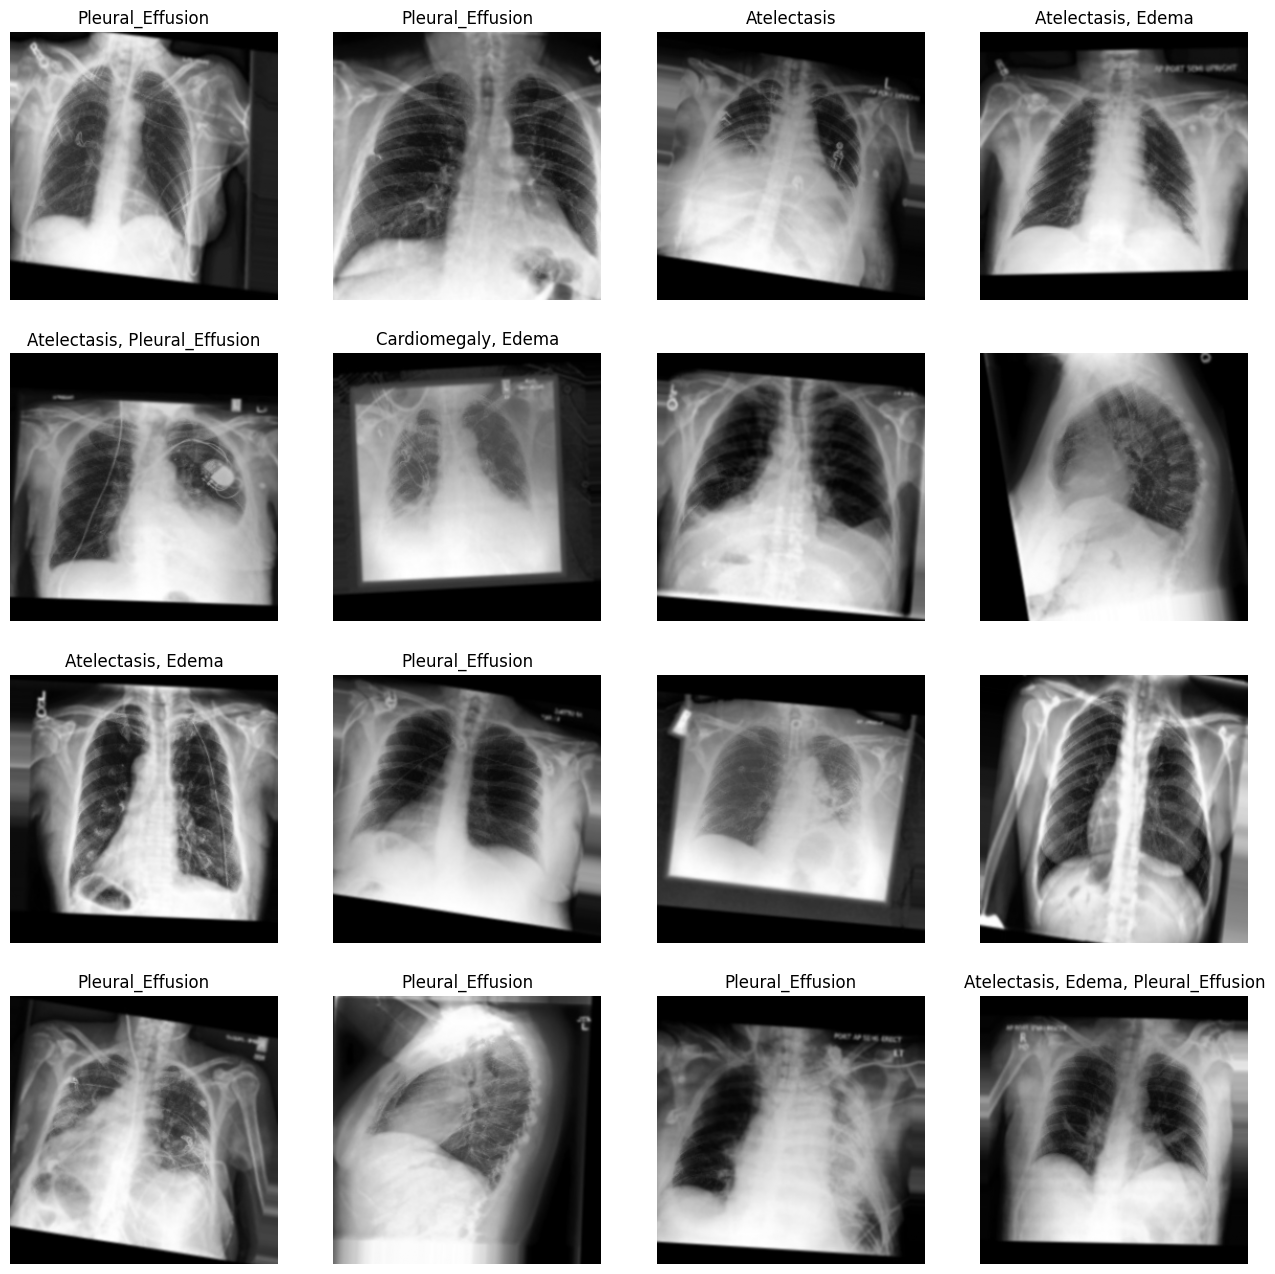

In [48]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,2], cmap='gray')
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(class_names, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# DenseNet Model 

My First Bookmark <a name='bookmark1' />

In [49]:
model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)

# Freeze sebagian besar layer
for layer in model.layers[:-30]:
    layer.trainable = False

x = model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(class_names), activation='sigmoid')(x)

model = tf.keras.Model(inputs=model.input, outputs=output)

In [50]:
from tensorflow.keras.losses import BinaryCrossentropy
loss_fn = BinaryCrossentropy(from_logits=False)

In [51]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.AUC(multi_label=True, name="auc")
    ]
)

In [52]:
cb = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    )
]

In [53]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5,
    callbacks=cb
)
model.save("densenet121_chexpert.keras")

c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 322s 499ms/step - auc: 0.5015 - loss: 0.5285 - val_auc: 0.5481 - val_loss: 0.4969 - learning_rate: 1.0000e-04
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 296s 474ms/step - auc: 0.5257 - loss: 0.5035 - val_auc: 0.5290 - val_loss: 0.5018 - learning_rate: 1.0000e-04
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 299s 479ms/step - auc: 0.5470 - loss: 0.4983 - val_auc: 0.5373 - val_loss: 0.5010 - learning_rate: 1.0000e-04
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 329s 526ms/step - auc: 0.5842 - loss: 0.4899 - val_auc: 0.5370 - val_loss: 0.4970 - learning_rate: 2.0000e-05
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 301s 481ms/step - auc: 0.5853 - loss: 0.4897 - val_auc: 0.5387 - val_loss: 0.4961 - learning_rate: 2.0000e-05


In [65]:
def learning_curves(history):
    # Ambil dictionary metric
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)

    import matplotlib.pyplot as plt
    import matplotlib.style as style
    style.use("bmh")

    # Membuat canvas 4 plot (loss, F1, macro AUC, micro AUC)
    plt.figure(figsize=(10, 14))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, hist['loss'], label='Training Loss')
    if 'val_loss' in hist:
        plt.plot(epochs, hist['val_loss'], label='Validation Loss')
    plt.legend()
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    # Plot AUC 
    plt.subplot(2, 1, 2)
    if 'auc' in hist:
        plt.plot(epochs, hist['auc'], label='Training AUC')
    if 'val_auc' in hist:
        plt.plot(epochs, hist['val_auc'], label='Validation AUC')
    plt.legend()
    plt.ylabel('AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epoch')

    plt.tight_layout()
    plt.show()


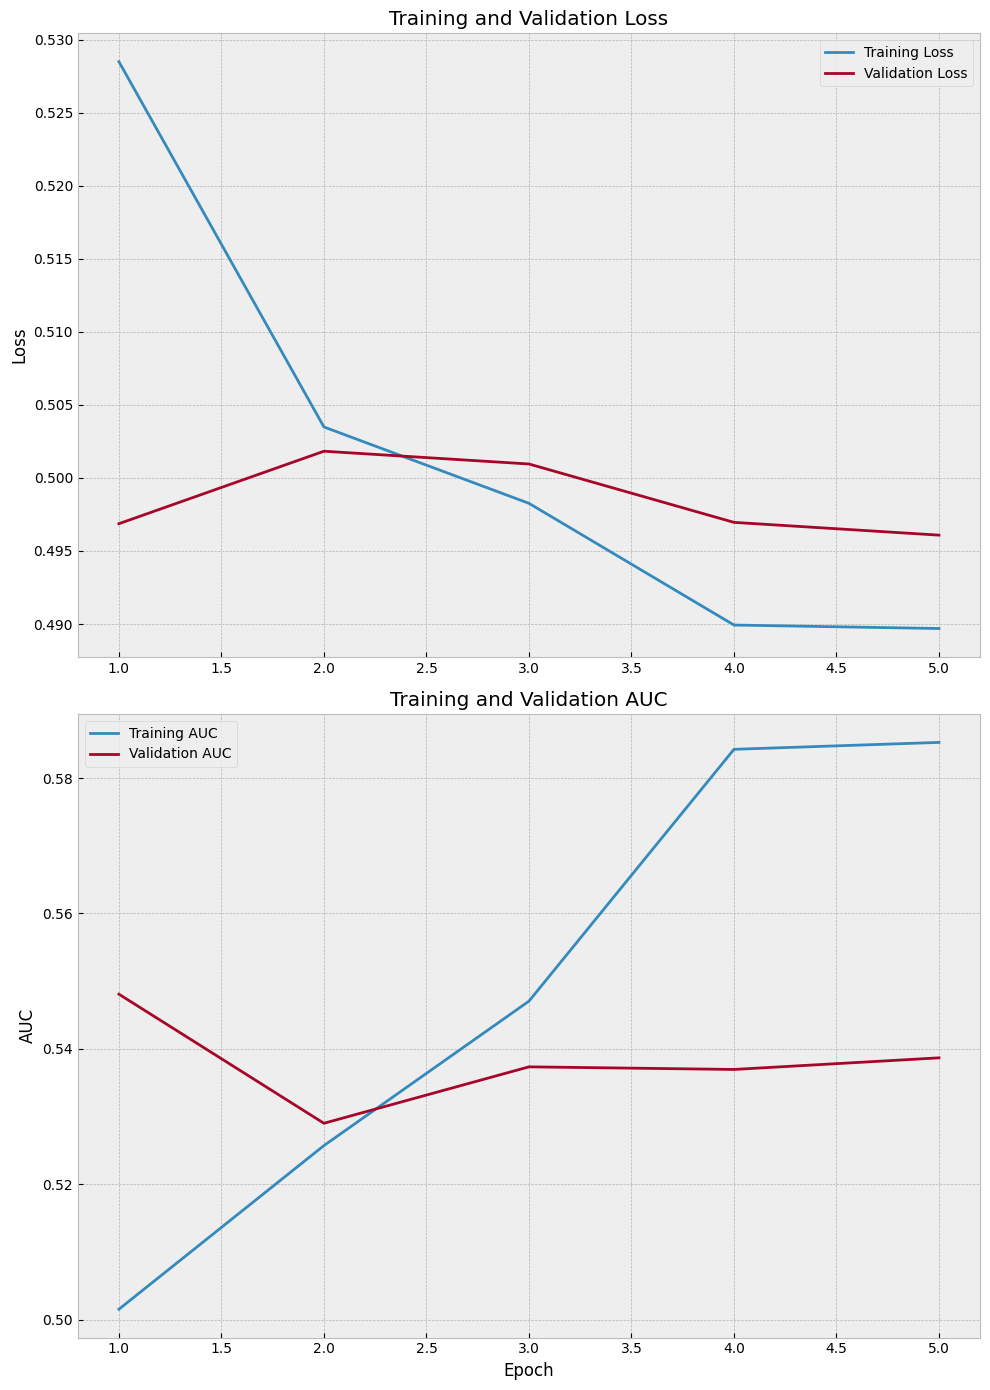

In [66]:
learning_curves(history)

Fungsi Evaluasi Confusion Matrix

In [67]:
def evaluate_confusion_matrices(model, valid_df, class_names, base_gen, IMG_SIZE, batch_size=16, thresh=0.1):
    from sklearn.metrics import confusion_matrix, classification_report, f1_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import math
    
    # Non shuffled generator for evaluation
    valid_eval_gen = base_gen.flow_from_dataframe(
        dataframe=valid_df,
        directory=None,
        x_col='path',
        y_col=class_names,
        class_mode='raw',
        target_size=IMG_SIZE,
        shuffle=False,
        batch_size=batch_size
    )

    # Predict
    preds = model.predict(valid_eval_gen, verbose=0)
    y_true = valid_df[class_names].to_numpy()
    y_pred = (preds >= thresh).astype(int)

    # Classification report
    print("Classification report (per-class):")
    print(classification_report(
        y_true, 
        y_pred, 
        target_names=class_names, 
        zero_division=0
    ))

    print("Macro F1 (sklearn):", f1_score(y_true, y_pred, average='macro'))
    print("Micro F1 (sklearn):", f1_score(y_true, y_pred, average='micro'))

    # Confusion matrices per class
    n = len(class_names)
    cols = 2
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten()

    for i, cls in enumerate(class_names):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=[0, 1])
        sns.heatmap(
            cm, 
            annot=True, 
            fmt="d", 
            cmap="Blues", 
            cbar=False,
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"],
            ax=axes[i]
        )
        axes[i].set_title(f"{cls} (Thresh={thresh})")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")

    # Hide unused subplot slots
    for j in range(n, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Classification report (per-class):
                  precision    recall  f1-score   support

     Atelectasis       0.29      1.00      0.45        67
    Cardiomegaly       0.16      0.89      0.27        38
   Consolidation       0.00      0.00      0.00        13
           Edema       0.24      1.00      0.38        55
Pleural_Effusion       0.34      1.00      0.50        79

       micro avg       0.26      0.93      0.40       252
       macro avg       0.20      0.78      0.32       252
    weighted avg       0.26      0.93      0.40       252
     samples avg       0.26      0.66      0.35       252

Macro F1 (sklearn): 0.32122260987048074
Micro F1 (sklearn): 0.40068201193520886


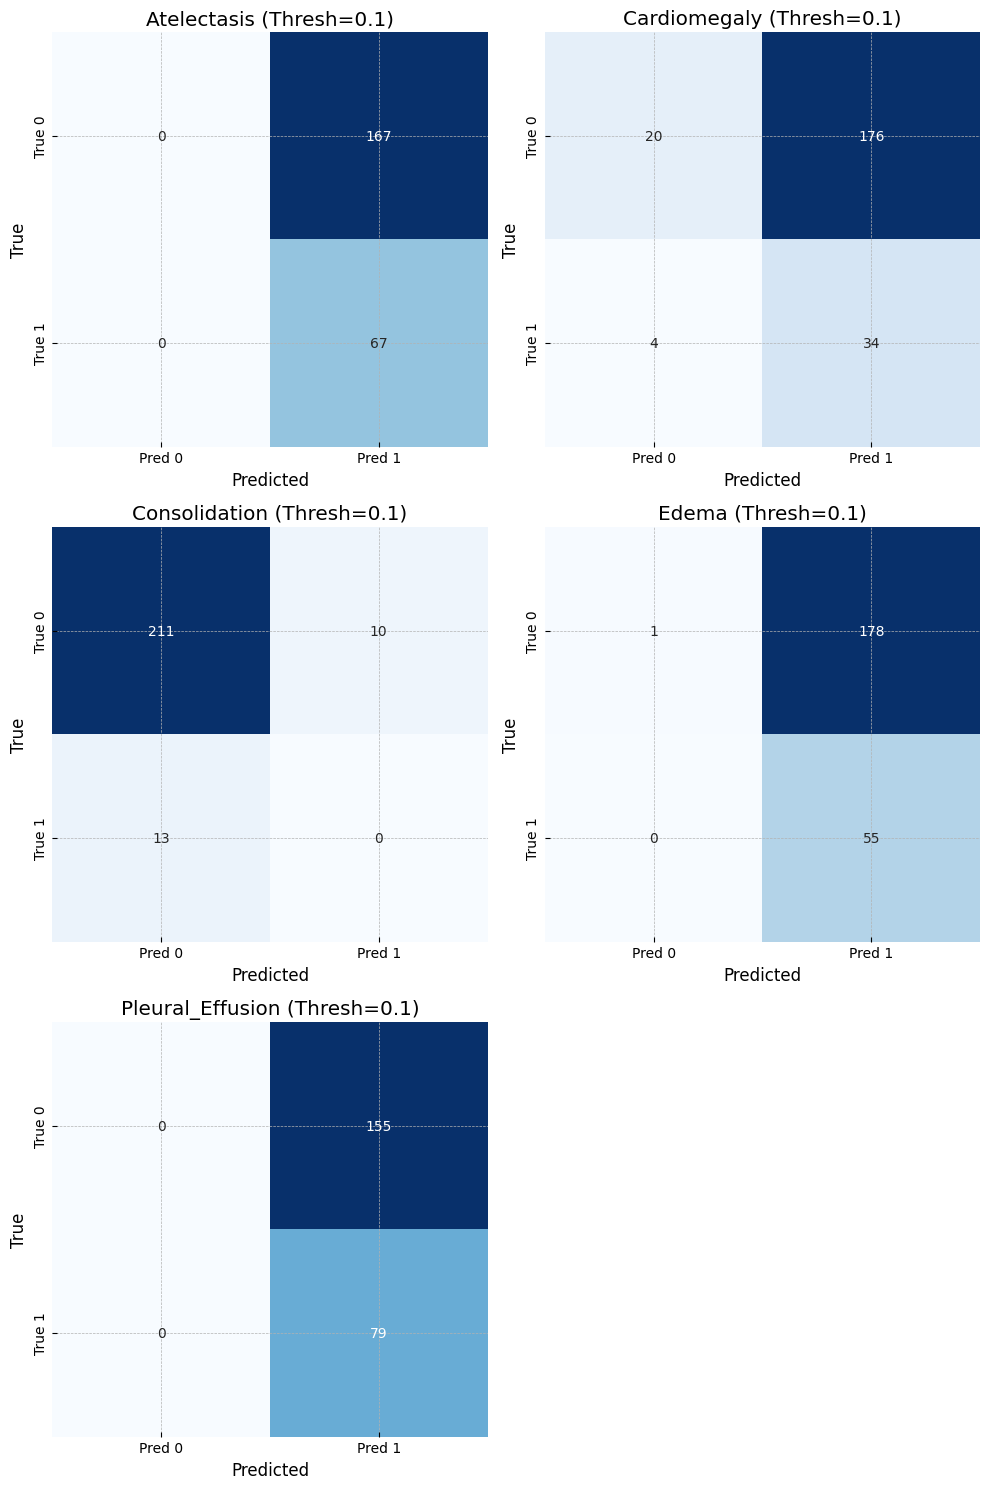

In [68]:
evaluate_confusion_matrices(model, valid_df, class_names, base_gen, IMG_SIZE)

Fungsi Penghitung AUC Validasi

In [69]:
from sklearn.metrics import roc_auc_score
import math

def evaluate_auc(model, valid_df, class_names, base_gen, IMG_SIZE):
    # deterministic validation generator
    BATCH_SIZE = 16

    valid_eval_gen = base_gen.flow_from_dataframe(
        dataframe=valid_df,
        directory=None,
        x_col='path',
        y_col=class_names,
        class_mode='raw',
        target_size=IMG_SIZE,
        shuffle=False,
        batch_size=BATCH_SIZE
    )

    # get prediction probabilities
    preds = model.predict(valid_eval_gen, verbose=1)
    y_true = valid_df[class_names].to_numpy()

    # compute AUC per class
    auc_per_class = {}
    for i, cls in enumerate(class_names):
        try:
            auc = roc_auc_score(y_true[:, i], preds[:, i])
        except ValueError:
            auc = float('nan')
        auc_per_class[cls] = auc

    print("\nAUC per class:")
    for cls, auc in auc_per_class.items():
        print(f"{cls}: {auc:.4f}")

    # macro and micro AUC
    try:
        macro_auc = roc_auc_score(y_true, preds, average='macro')
    except ValueError:
        macro_auc = float('nan')

    try:
        micro_auc = roc_auc_score(y_true, preds, average='micro')
    except ValueError:
        micro_auc = float('nan')

    print("\nMacro AUC:", macro_auc)
    print("Micro AUC:", micro_auc)

    # optional: plot ROC curves for each class
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve

    cols = 2
    rows = math.ceil(len(class_names) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten()

    for i, cls in enumerate(class_names):
        try:
            fpr, tpr, _ = roc_curve(y_true[:, i], preds[:, i])
            axes[i].plot(fpr, tpr, label=f"AUC={auc_per_class[cls]:.3f}")
            axes[i].plot([0,1], [0,1], 'k--')
            axes[i].set_title(cls)
            axes[i].set_xlabel("False Positive Rate")
            axes[i].set_ylabel("True Positive Rate")
            axes[i].legend()
        except ValueError:
            axes[i].set_title(f"{cls} (no positives)")
            axes[i].axis("off")

    # hide unused plots
    for j in range(len(class_names), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 438ms/step

AUC per class:
Atelectasis: 0.5309
Cardiomegaly: 0.5265
Consolidation: 0.5573
Edema: 0.4705
Pleural_Effusion: 0.4764

Macro AUC: 0.5123035632813944
Micro AUC: 0.6531754677179514


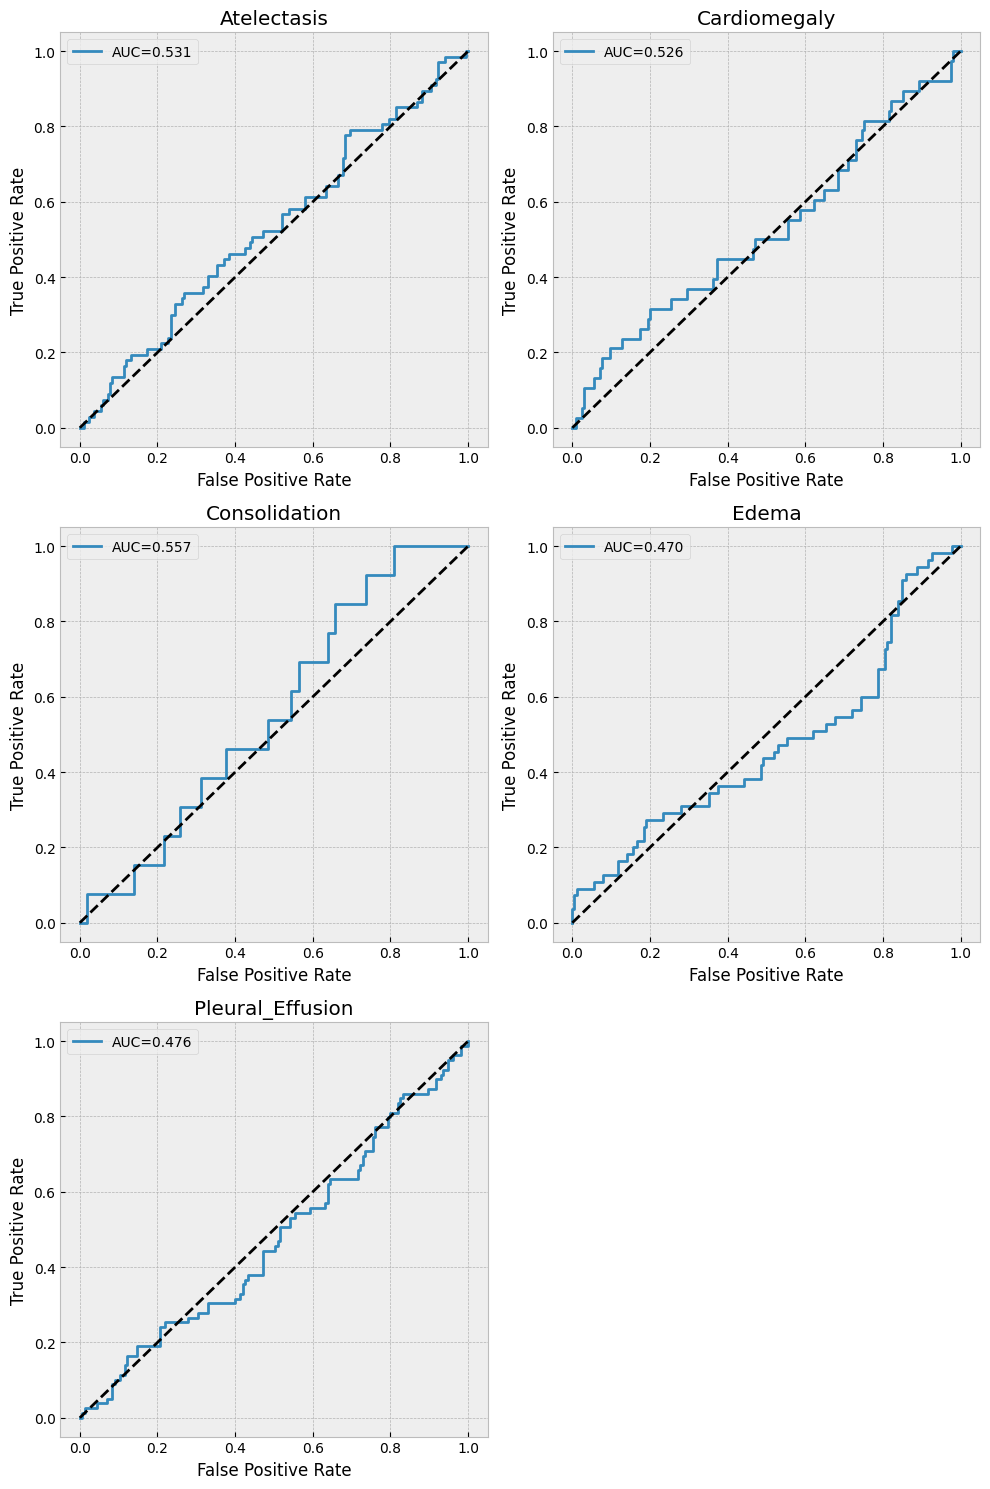

In [70]:
evaluate_auc(model, valid_df, class_names, base_gen, IMG_SIZE)

# CNN Model

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop

def build_simple_cnn(input_shape=(256,256,3), n_classes=len(class_names)):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(n_classes, activation='sigmoid'))
    return model


In [76]:
# build model
cnn_input_shape = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)
cnn_model = build_simple_cnn(input_shape=cnn_input_shape, n_classes=len(class_names))

# use BinaryCrossentropy
loss_fn = BinaryCrossentropy(from_logits=False)

cnn_model.compile(
    optimizer=RMSprop(learning_rate=3e-5),
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.AUC(multi_label=True, name="auc")
    ]
)

# deterministic generators
cnn_valid_eval_gen = base_gen_valid.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=False,
    batch_size=16
)

cnn_train_gen = base_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=True,
    batch_size=16
)

Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 10000 validated image filenames.


In [79]:
# training
H_cnn = cnn_model.fit(
    cnn_train_gen,
    validation_data=(test_X, test_Y),
    epochs=5,
    callbacks=cb
)

cnn_model.save('simple_cnn.keras')

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 345s 551ms/step - auc: 0.5092 - loss: 0.5690 - val_auc: 0.3679 - val_loss: 0.8189 - learning_rate: 6.0000e-06
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 343s 548ms/step - auc: 0.5012 - loss: 0.5672 - val_auc: 0.3652 - val_loss: 0.8278 - learning_rate: 6.0000e-06
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 349s 559ms/step - auc: 0.5145 - loss: 0.5594 - val_auc: 0.3711 - val_loss: 0.8320 - learning_rate: 1.2000e-06
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 406s 649ms/step - auc: 0.5103 - loss: 0.5619 - val_auc: 0.3696 - val_loss: 0.8366 - learning_rate: 1.2000e-06


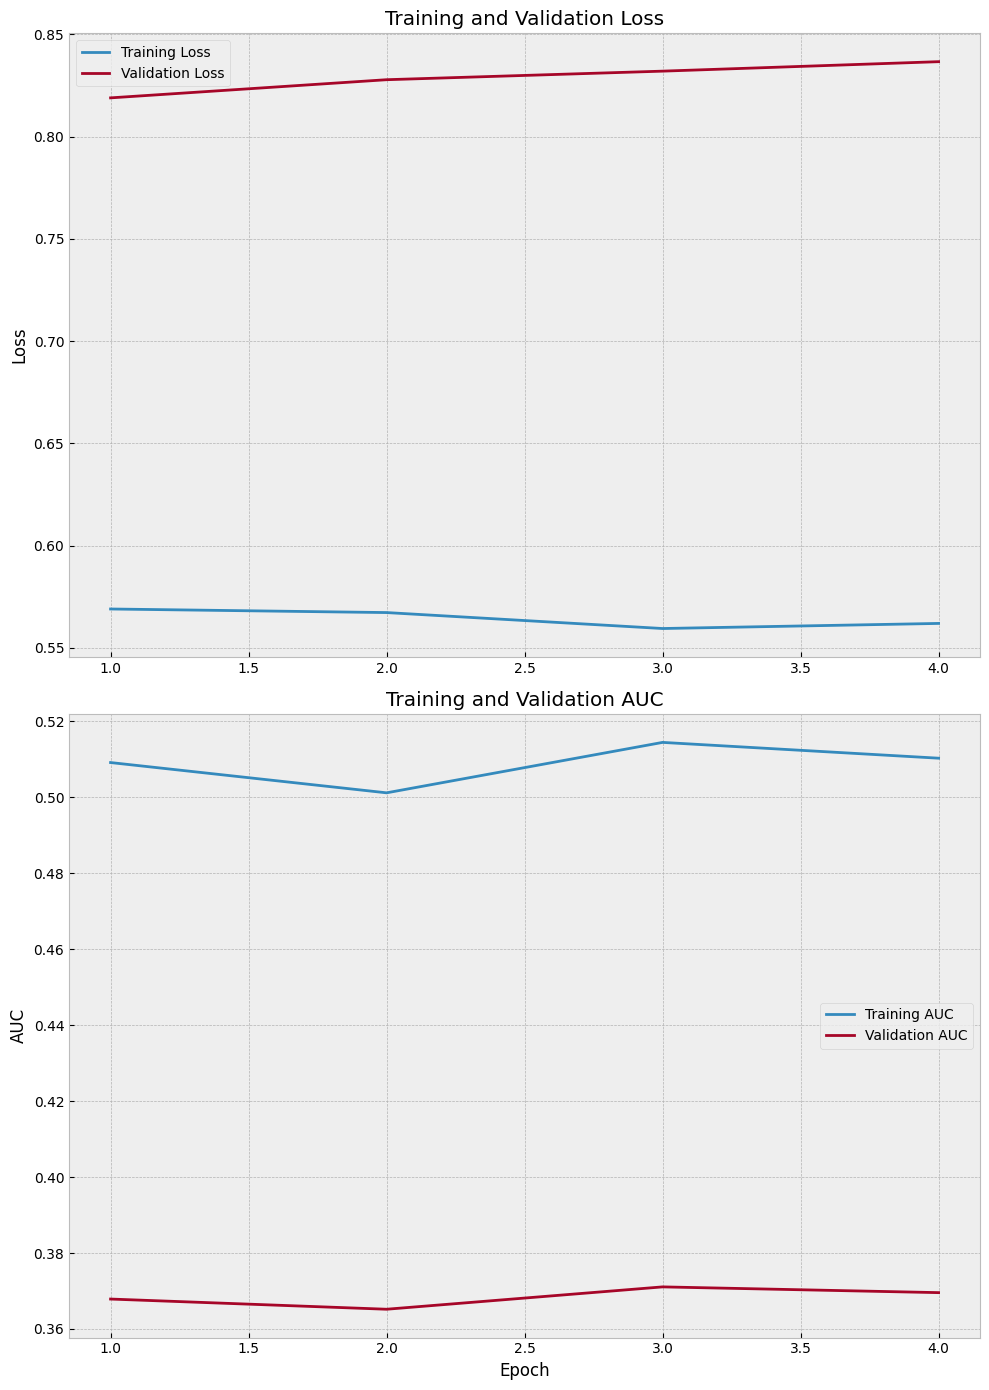

In [80]:
learning_curves(H_cnn)

Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Classification report (per-class):
                  precision    recall  f1-score   support

     Atelectasis       0.29      1.00      0.45        67
    Cardiomegaly       0.00      0.00      0.00        38
   Consolidation       0.00      0.00      0.00        13
           Edema       0.24      1.00      0.38        55
Pleural_Effusion       0.34      1.00      0.50        79

       micro avg       0.29      0.80      0.42       252
       macro avg       0.17      0.60      0.27       252
    weighted avg       0.23      0.80      0.36       252
     samples avg       0.29      0.57      0.36       252

Macro F1 (sklearn): 0.2661195787782209
Micro F1 (sklearn): 0.42138364779874216


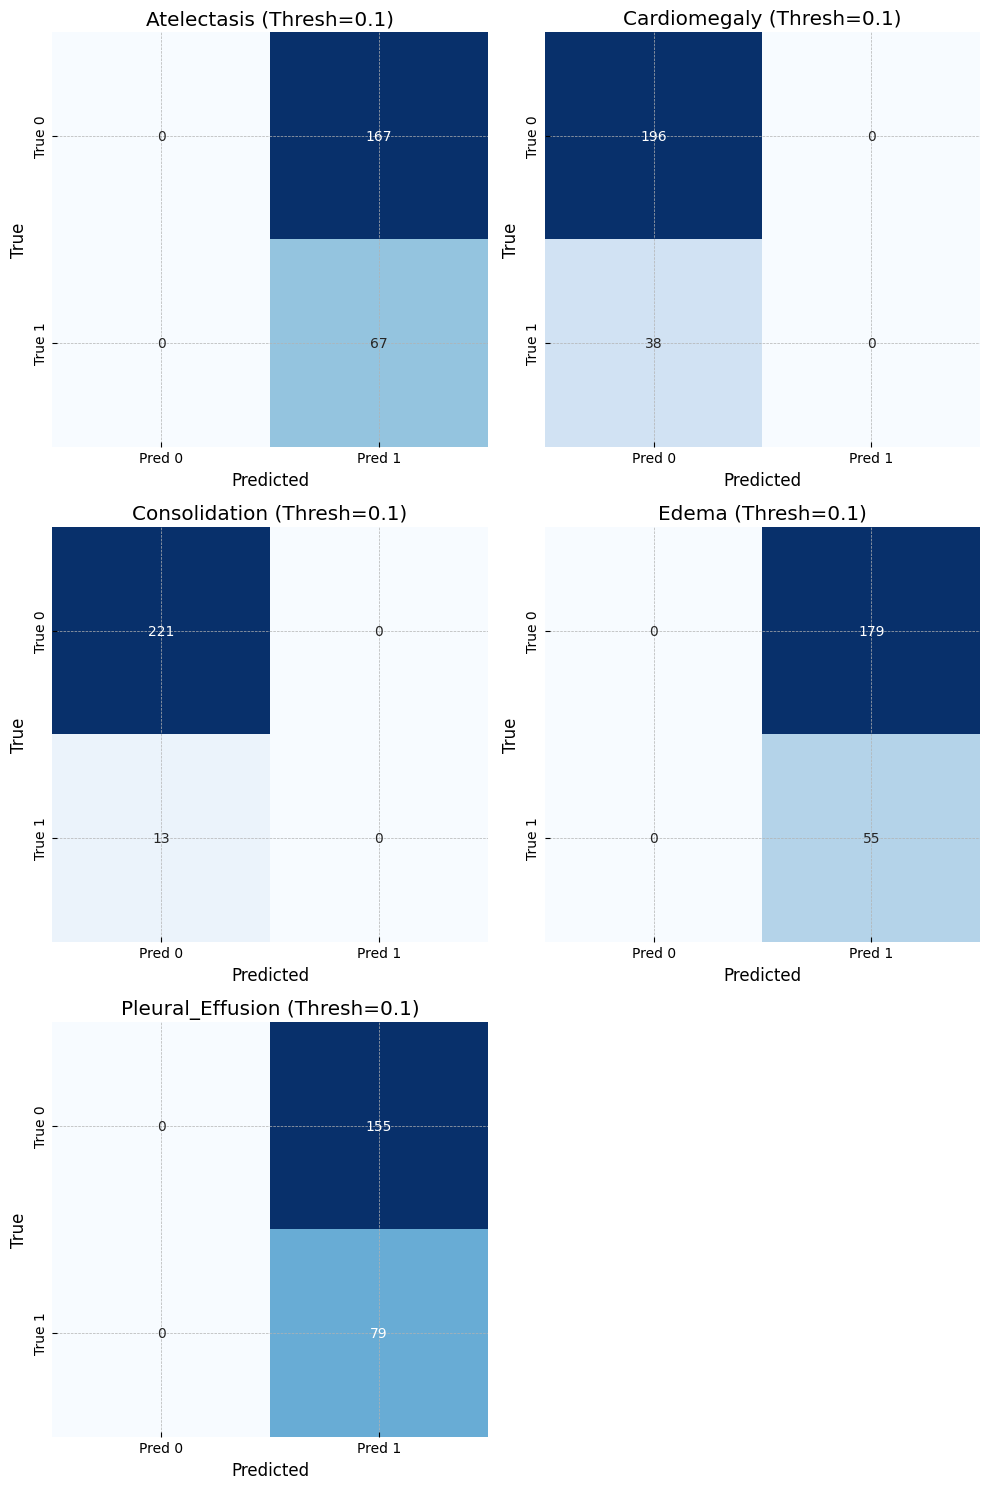

In [81]:
evaluate_confusion_matrices(cnn_model, valid_df, class_names, base_gen, IMG_SIZE)

Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step

AUC per class:
Atelectasis: 0.4627
Cardiomegaly: 0.4737
Consolidation: 0.5392
Edema: 0.5159
Pleural_Effusion: 0.4988

Macro AUC: 0.49804813798095343
Micro AUC: 0.6219524846975828


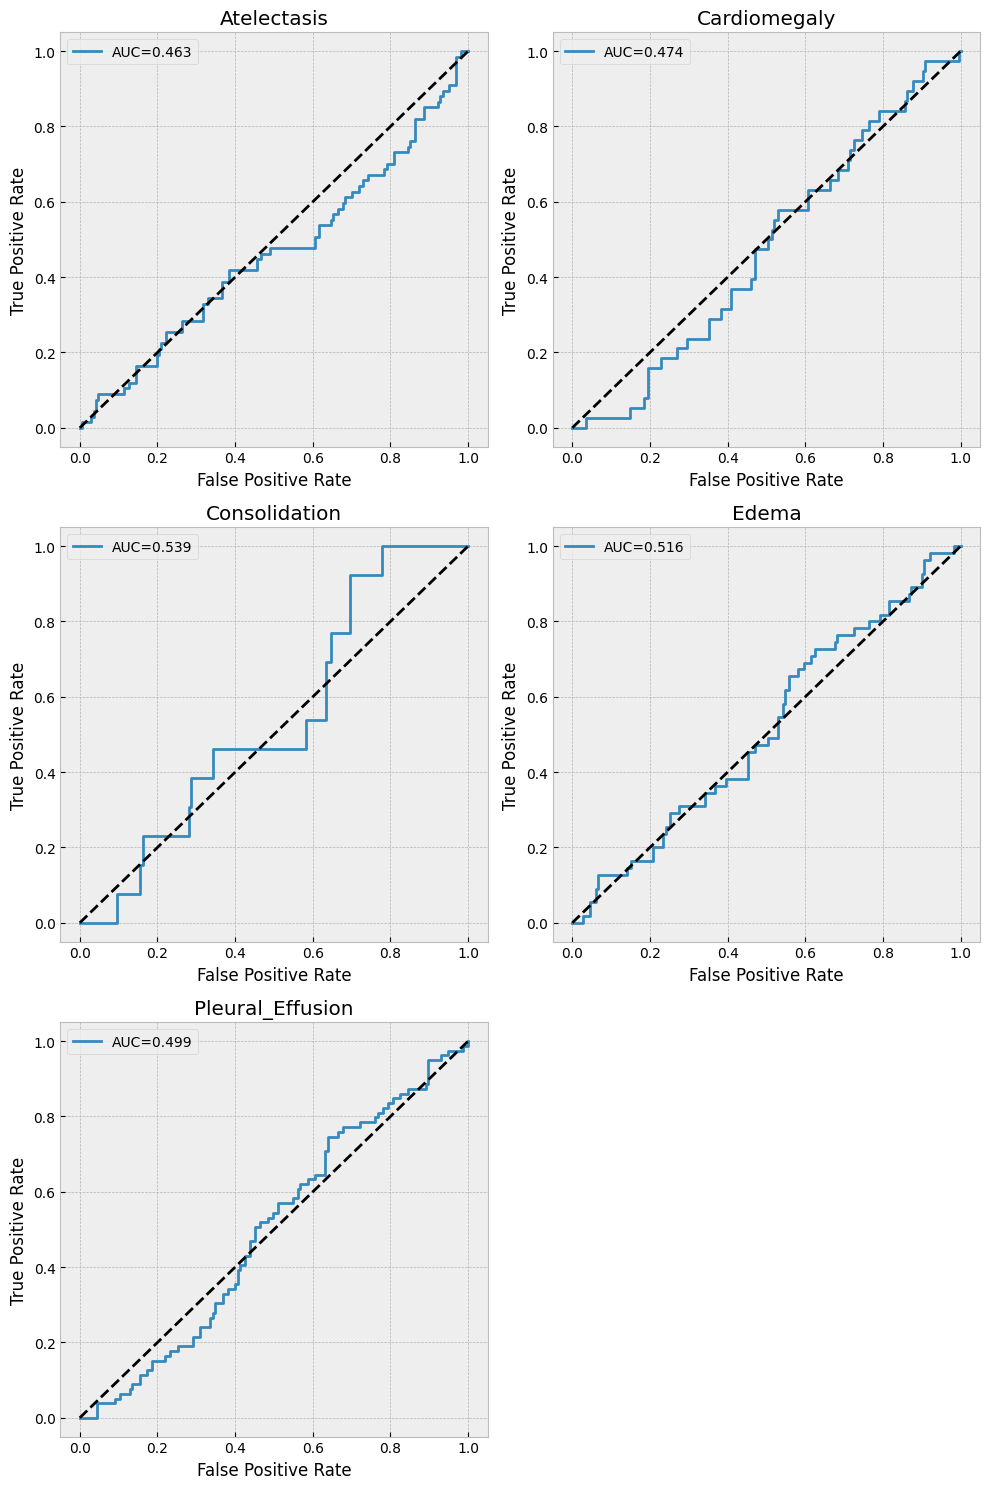

In [82]:
evaluate_auc(cnn_model, valid_df, class_names, base_gen, IMG_SIZE)

# ResNet-50

In [83]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import tensorflow as tf

def build_resnet50(input_shape=(256,256,3), n_classes=len(class_names), trainable=False):
    base_model_r = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model_r.trainable = trainable

    x = base_model_r.output
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(n_classes, activation='sigmoid')(x)

    model_r = tf.keras.Model(inputs=base_model_r.input, outputs=outputs)
    return model_r



In [84]:
# Build, compile and train ResNet50 model
resnet_input_shape = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)
resnet_model = build_resnet50(
    input_shape=resnet_input_shape,
    n_classes=len(class_names),
    trainable=False
)

resnet_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=3e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.AUC(multi_label=True, name="auc")
    ]
)

# Generators
resnet_train_gen = base_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=True,
    batch_size=16
)

resnet_valid_eval_gen = base_gen_valid.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=False,
    batch_size=16
)


Found 10000 validated image filenames.
Found 234 validated image filenames.


In [85]:
# Train
H_resnet = resnet_model.fit(
    resnet_train_gen,
    validation_data=(test_X, test_Y),
    epochs=5,
    callbacks=cb
)
resnet_model.save("ResNet50.keras")

c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 414ms/step - auc: 0.4949 - loss: 0.5200 - val_auc: 0.4642 - val_loss: 0.5183 - learning_rate: 3.0000e-05
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 257s 410ms/step - auc: 0.4990 - loss: 0.4971 - val_auc: 0.4920 - val_loss: 0.5150 - learning_rate: 3.0000e-05
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 257s 411ms/step - auc: 0.4950 - loss: 0.4970 - val_auc: 0.4871 - val_loss: 0.5167 - learning_rate: 6.0000e-06
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 257s 411ms/step - auc: 0.4960 - loss: 0.4969 - val_auc: 0.5096 - val_loss: 0.5162 - learning_rate: 6.0000e-06


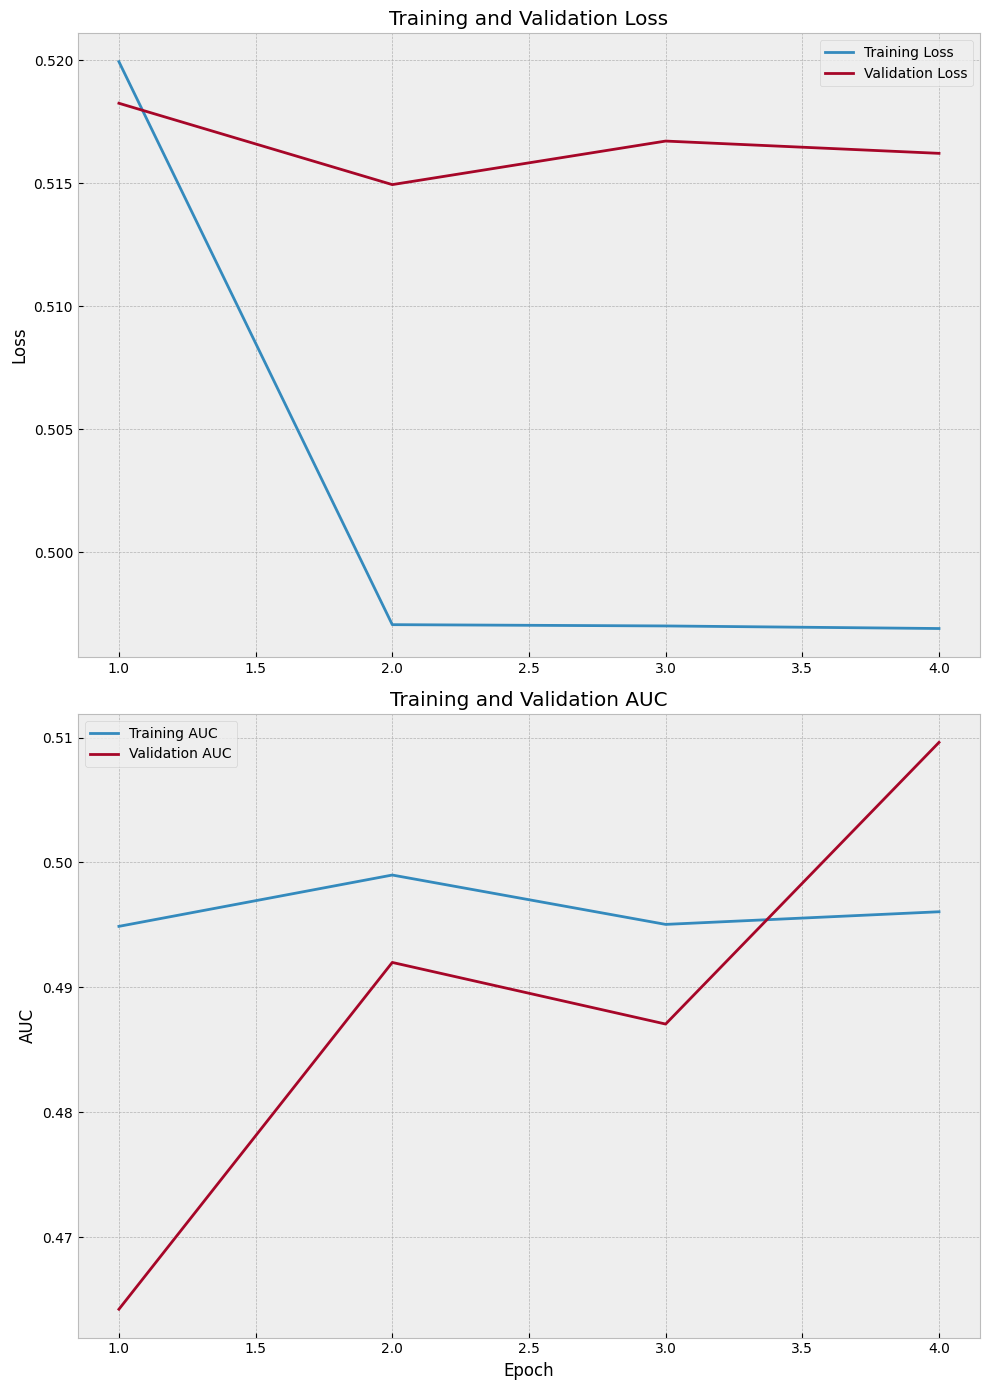

In [86]:
learning_curves(H_resnet)

Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Classification report (per-class):
                  precision    recall  f1-score   support

     Atelectasis       0.29      1.00      0.45        67
    Cardiomegaly       0.16      1.00      0.28        38
   Consolidation       0.00      0.00      0.00        13
           Edema       0.24      1.00      0.38        55
Pleural_Effusion       0.34      1.00      0.50        79

       micro avg       0.26      0.95      0.40       252
       macro avg       0.20      0.80      0.32       252
    weighted avg       0.26      0.95      0.40       252
     samples avg       0.26      0.67      0.35       252

Macro F1 (sklearn): 0.3220019317193974
Micro F1 (sklearn): 0.40235690235690236


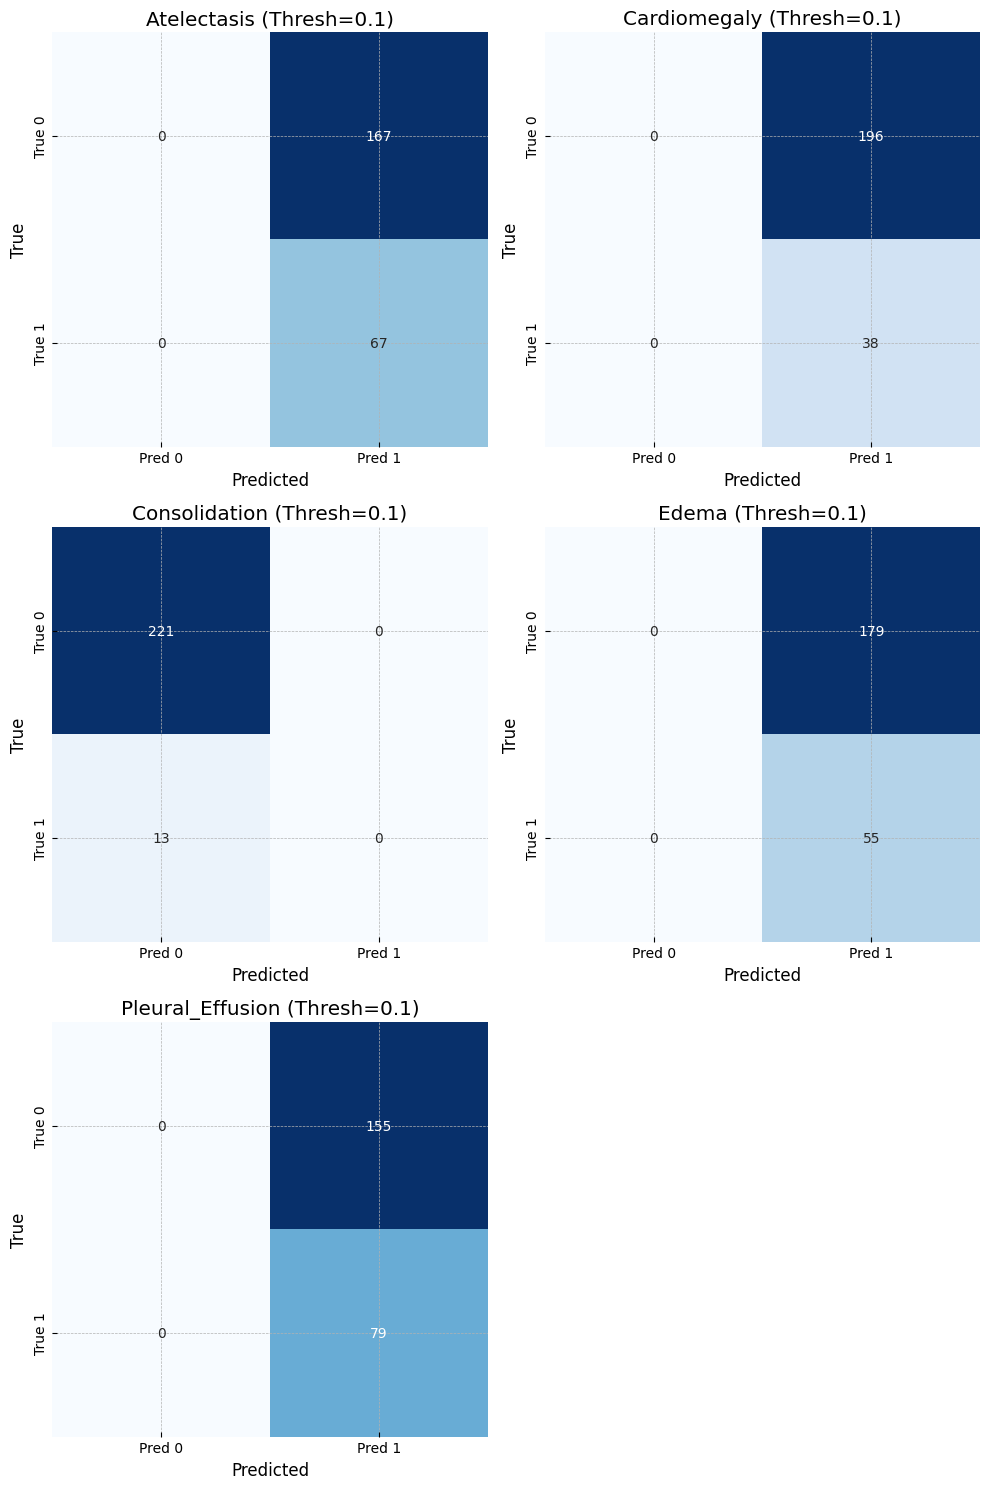

In [87]:
evaluate_confusion_matrices(resnet_model, valid_df, class_names, base_gen_valid, IMG_SIZE)

Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step

AUC per class:
Atelectasis: 0.5294
Cardiomegaly: 0.4703
Consolidation: 0.4243
Edema: 0.5826
Pleural_Effusion: 0.4605

Macro AUC: 0.49344332097800014
Micro AUC: 0.6638093509008542


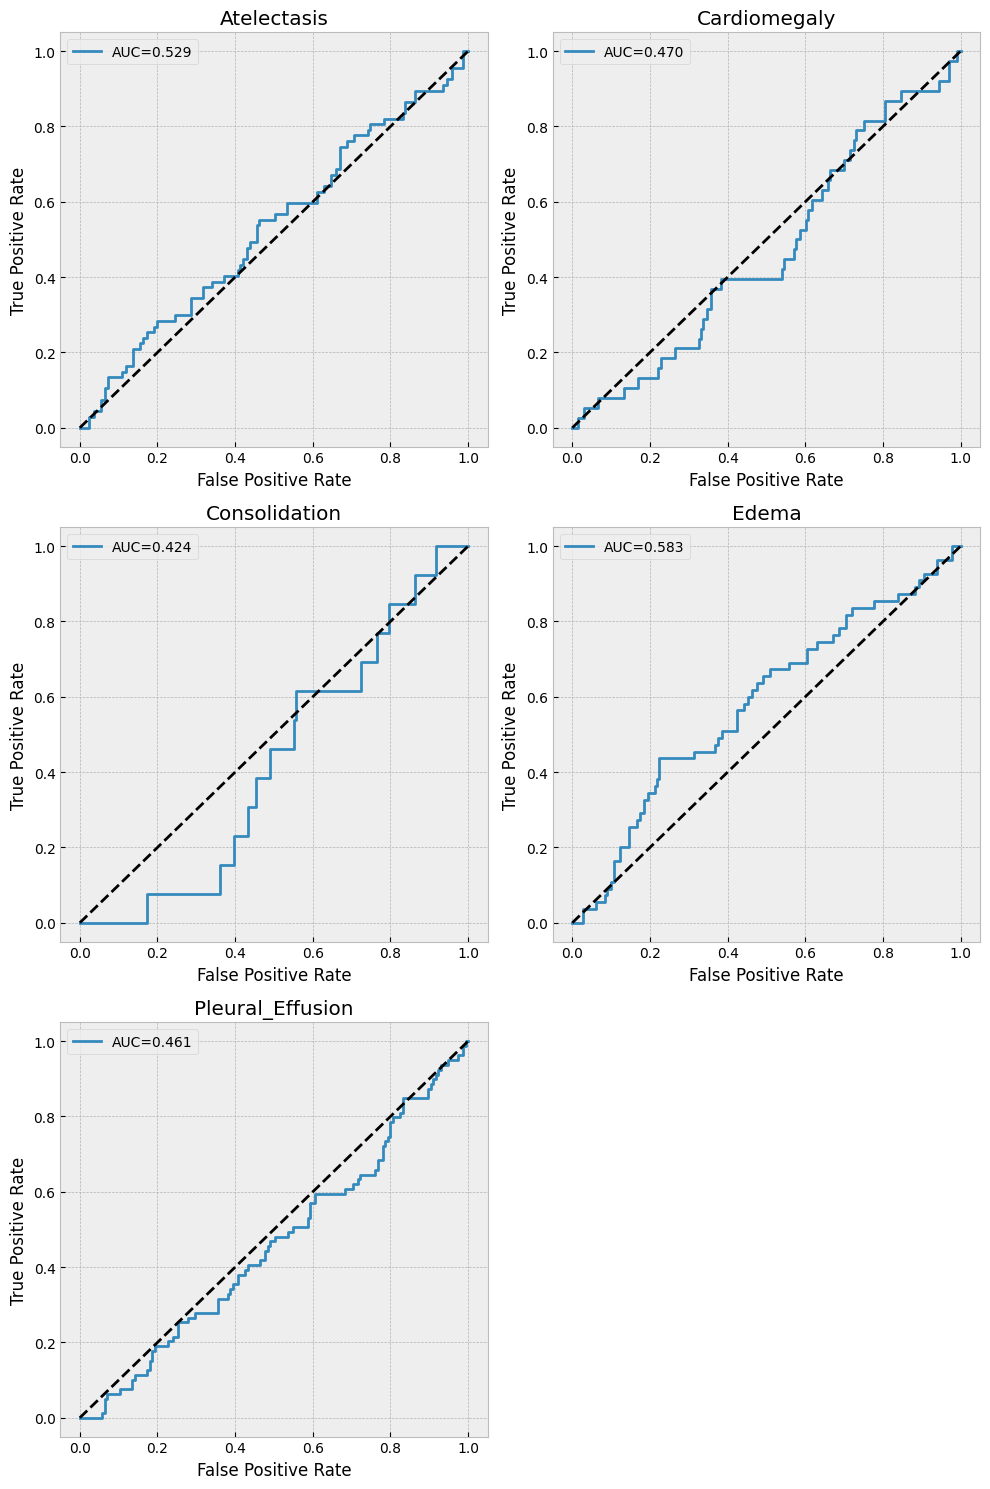

In [88]:
evaluate_auc(resnet_model, valid_df, class_names, base_gen, IMG_SIZE)   